# LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv


In [26]:
import warnings
warnings.filterwarnings('ignore')


In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional


# I. Colab File Upload

> ## 1) 'Seoul_temp.csv' 파일을 Colab에 업로드

In [28]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing


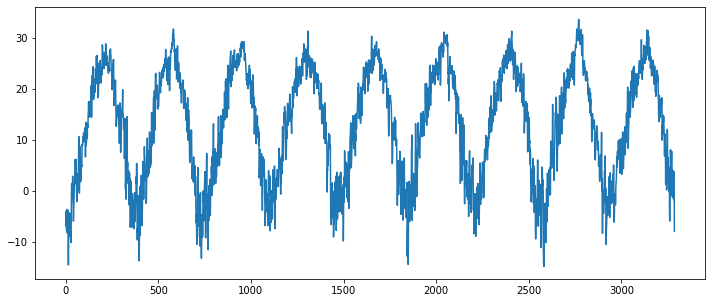

In [29]:
# 일일 평균온도 변화에 일정한 패턴 확인
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

In [30]:
# tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화
scaler = MinMaxScaler(feature_range = (-1, 1))
temp_data = scaler.fit_transform(temp_data)


> ## 3) Train vs. Test Split


* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일


In [31]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수


> ## 1) 시계열 학습용 데이터 생성 함수 정의


* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습


In [32]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []
    
    for i in range(len(time_data) - look_back):
      data_X.append(time_data[i:(i + look_back), 0])
      data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

In [33]:
# 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [34]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y  = create_dataset(test, look_back)


> ## 3) Tensor Reshape

In [35]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape


((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# IV. Bidirectional LSTM Modeling

> ## 1) Model Define

In [36]:
model = Sequential()
model.add(Bidirectional(LSTM(64,
                             input_shape = (None, 1))))
model.add(Dense(1, activation = 'tanh'))

In [38]:
# model.summary()

> ## 2) Model Compile

In [39]:
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

> ## 3) Model Fit

In [40]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))


Epoch 1/200
149/149 [==============================] - 35s 22ms/step - loss: 0.0368 - val_loss: 0.0148
Epoch 2/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0166 - val_loss: 0.0138
Epoch 3/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 4/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 5/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0118 - val_loss: 0.0097
Epoch 6/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 7/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0098 - val_loss: 0.0084
Epoch 8/200
149/149 [==============================] - 3s 18ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 9/200
149/149 [==============================] - 3s 17ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 10/200
149/149 [==============================] - 3s 17ms/step - loss: 0.00

> ## 4) 학습결과 시각화

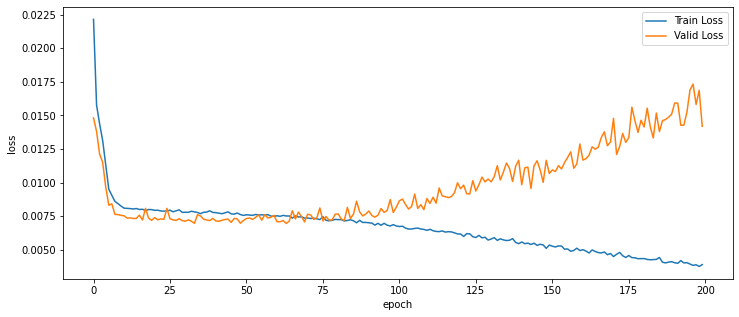

In [41]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()


> ## 5) Model Evaluate

In [42]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)


Train Score:  0.003788168076425791
Test Score:  0.014182964339852333


# V. Model Predict

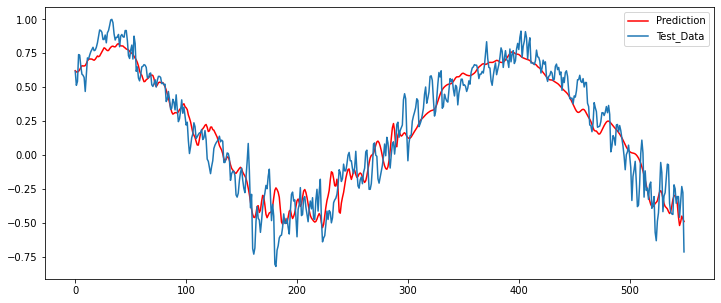

In [45]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()
